In [1]:
%load_ext autoreload
%autoreload 2

let's look at behavior of variance estimation and eigval estimation for K = 2..10


cases:
- trials L = 5, 10, 15, 20, 25
- complex gaussian / real gaussian
- rank 1, rank 2, ... full rank


In [2]:
import os
import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt

from cohlib.jax.dists import sample_from_gamma, sample_obs, sample_ccn_rank1
# from cohlib.jax.observations import add0
# from cohlib.jax.simtools import load_gamma, construct_gamma_init

from cohlib.utils import pickle_open, gamma_root

In [3]:
K = 3
gamma_name = f'k{K}-log-chlg3-rank1-nz9'
# print(f"N = {N}, L = {L}, gamma = {gamma_name}")
gamma_path = os.path.join(gamma_root(), f"{gamma_name}.pkl")
gamma_load = pickle_open(gamma_path)
gamma_full = gamma_load['gamma']
K = gamma_full.shape[-1]
eigvec = gamma_load['eigvec']
eigval = gamma_load['eigval']

nz_target = gamma_load['target_inds']
gamma_true = gamma_full[nz_target,:,:].squeeze()


L = 50
seed = 7
lrk = jr.key(seed)

zs = sample_ccn_rank1(lrk, eigvec, eigval, K, L)
oracle_est = jnp.einsum('jl,kl->jkl', zs, zs.conj()).mean(-1)

In [4]:
zs.shape

(3, 50)

In [5]:
u = jr.normal(jr.key(seed), (3,)) + jr.normal(jr.key(seed), (3,))*1j
u = u / jnp.linalg.norm(u)

In [6]:
uuH = jnp.outer(eigvec, eigvec.conj())
quadsum = jnp.einsum('jl,jk,kl->l', zs.conj(), uuH, zs).sum()
test = quadsum/L

In [7]:
gamma_oracle = jnp.einsum('kl,il->kil', zs, zs.conj()).mean(-1)
test2 = jnp.trace(uuH @ gamma_oracle).real

In [8]:
oracle_evs, _ = jnp.linalg.eigh(oracle_est)
print(oracle_evs[-1])
print(test.real)
print(test2)
print(eigval)

2570320.0
2570319.8
2570319.8
3000000.0


In [9]:
uuH = jnp.outer(eigvec, eigvec.conj())
quadsum = jnp.einsum('jl,jk,kl->l', zs.conj(), uuH, zs).sum()
test = quadsum/L

In [25]:
temp = jnp.stack([gamma_true for _ in range(5)]).shape



TypeError: unsupported operand type(s) for @: 'ArrayImpl' and 'tuple'

In [26]:
zs.shape

(3, 50)

In [30]:
import jax
from functools import partial
def cost_func_full(ev, zs, u):
    L = zs.shape[1]
    uuH = jnp.outer(u, u.conj())

    zzH = jnp.einsum('kl,il->kil', zs, zs.conj()).sum(-1)
    quadsum = jnp.trace(uuH @ zzH).real
    logL = -L*jnp.log(ev) - (1/ev)*quadsum
    return -logL.real

In [31]:
cost_func = partial(cost_func_full, zs=zs, u=eigvec)
cost_grad = jax.grad(cost_func)
cost_hess = jax.hessian(cost_func)

ev_init = 1e3
ev_est = jnp.array(ev_init)
c = cost_func(ev_est)
g = cost_grad(ev_est)

costs = []
vals = []
num_steps = 100
for s in range(num_steps):
    c = cost_func(ev_est)
    g = cost_grad(ev_est)
    H = cost_hess(ev_est)
    costs.append(c)

    ev_est = ev_est - (1/H)*g
    vals.append(ev_est)





Text(0.5, 1.0, '$\\gamma$ est')

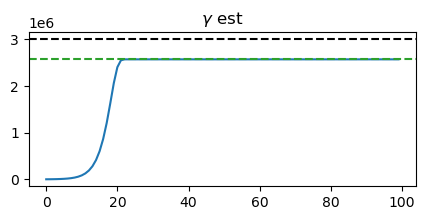

In [32]:
fig, ax = plt.subplots(figsize=(5,2))
ax.plot(jnp.stack(vals))
ax.axhline(eigval, linestyle='dashed', color='k')
ax.axhline(oracle_evs[-1], linestyle='dashed', color='tab:green')
ax.set_title('$\\gamma$ est')

Text(0.5, 1.0, 'Cost')

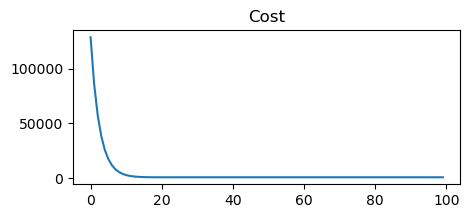

In [11]:
fig, ax = plt.subplots(figsize=(5,2))
ax.plot(jnp.stack(costs))
ax.set_title('Cost')

In [12]:
def cost_func_full_eigvec(u, zs, ev):
    return cost_func_full(ev, zs, u)

cost_func = partial(cost_func_full_eigvec, zs=zs, ev=eigval)
cost_grad = jax.grad(cost_func)
cost_hess = jax.hessian(cost_func)

# u_init = eigvec
useed = 20
u_init = jr.normal(jr.key(useed), (3,)) + jr.normal(jr.key(useed+1), (3,))*1j
u_init = u_init / jnp.linalg.norm(u_init)
u_est = u_init

vals = []
vals.append(u_est)
costs = []
c = cost_func(u_est)
costs.append(c)
num_steps = 10

nu = 1
renorm = True
method = 'GD'
for s in range(num_steps):
    c = cost_func(u_est)
    g = cost_grad(u_est).conj()
    if method == 'Newton':
        H_real = cost_hess(u_est.real)
        H_imag = cost_hess(u_est.imag)
        H = (H_real - H_imag*1j).conj()

        u_est = u_est - jnp.linalg.inv(H) @ g
    elif method == 'GD':
        u_est = u_est - nu*g

    if renorm is True:
        u_est = u_est/jnp.linalg.norm(u_est)
        angle1 = jnp.angle(u_est)[0]
        u_est = u_est * jnp.exp(-1j*angle1)


    costs.append(c)
    vals.append(u_est)

In [13]:
colors = ['tab:blue', 'tab:orange', 'tab:green']

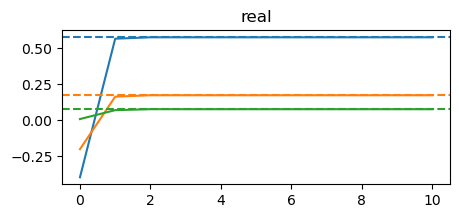

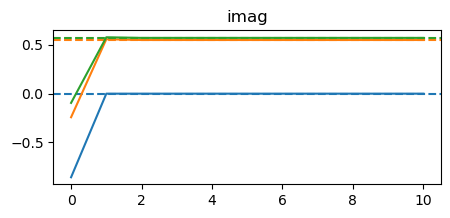

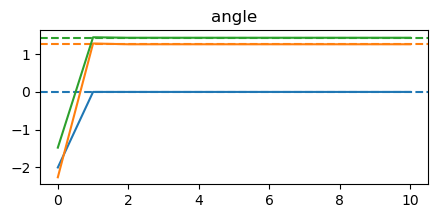

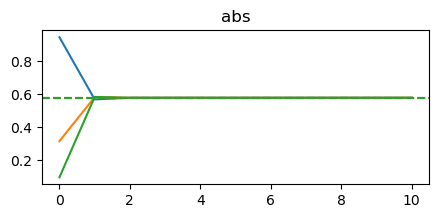

In [14]:
apps = [jnp.real, jnp.imag, jnp.angle, jnp.abs]

angle1 = jnp.angle(eigvec)[0]
eigvec_zeroed = eigvec * jnp.exp(-1j*angle1)

for app in apps:
    app_name = app.__name__
    fig, ax = plt.subplots(figsize=(5,2))
    def func(uiters, params):
        k = params[0]
        return app(uiters[:,k])
            

    for k in range(K):
        params = [k]
        ax.plot(func(jnp.stack(vals), params), color=colors[k])
        ax.axhline(app(eigvec_zeroed[k]), linestyle='dashed', color=colors[k])
    ax.set_title(f'{app_name}')
    plt.show()

In [15]:
def eigvec_optim(ev_est, zs, u_init, step_size=1, num_steps=5, ts=False):
    cost_func = partial(cost_func_full_eigvec, zs=zs, ev=ev_est)
    cost_grad = jax.grad(cost_func)
    nu = step_size
    renorm = True
    method = 'GD'

    u_ests = []
    costs = []
    u_est = u_init
    u_ests.append(u_est)
    c = cost_func(u_est)
    costs.append(c)
    for s in range(num_steps):
        g = cost_grad(u_est).conj()
        if method == 'Newton':
            H_real = cost_hess(u_est.real)
            H_imag = cost_hess(u_est.imag)
            H = (H_real - H_imag*1j).conj()

            u_est = u_est - jnp.linalg.inv(H) @ g
        elif method == 'GD':
            u_est = u_est - nu*g
        else: 
            raise ValueError

        if renorm is True:
            u_est = u_est/jnp.linalg.norm(u_est)
            angle1 = jnp.angle(u_est)[0]
            u_est = u_est * jnp.exp(-1j*angle1)

        u_ests.append(u_est)

        c = cost_func(u_est)
        costs.append(c)
    if ts is True:
        return u_ests, costs
    else:
        return u_est

In [16]:
# def eigvec_optim(ev_est, zs, u_init)
eigval
# vals, costs = eigvec_optim(eigval, zs, u_init, ts=True)
u_init_std = jnp.ones_like(u_init)
u_init_std = u_init_std / jnp.linalg.norm(u_init_std)

vals, costs = eigvec_optim(eigval, zs, u_init_std, ts=True)

In [35]:
vals

[Array([0.57735026+0.j, 0.57735026+0.j, 0.57735026+0.j], dtype=complex64),
 Array([0.57915926-2.096965e-08j, 0.16489756+5.520438e-01j,
        0.06646135+5.728996e-01j], dtype=complex64),
 Array([0.57732916+3.0633252e-08j, 0.17446128+5.5037522e-01j,
        0.0774359 +5.7214093e-01j], dtype=complex64),
 Array([0.5773505 -1.2361852e-08j, 0.17434828+5.5039603e-01j,
        0.07730616+5.7215124e-01j], dtype=complex64),
 Array([0.5773503 +3.828461e-08j, 0.17434959+5.503958e-01j,
        0.07730764+5.721511e-01j], dtype=complex64),
 Array([0.57735026-6.5767047e-08j, 0.17434965+5.5039585e-01j,
        0.07730773+5.7215106e-01j], dtype=complex64)]

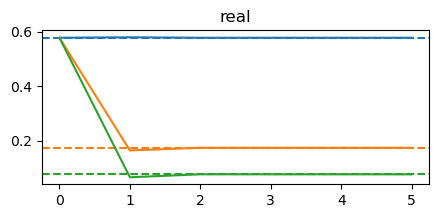

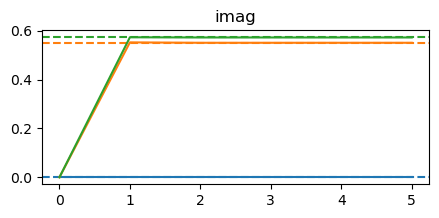

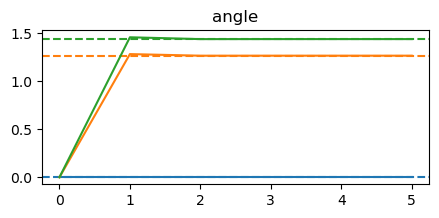

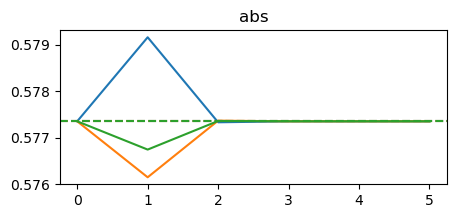

In [36]:
apps = [jnp.real, jnp.imag, jnp.angle, jnp.abs]

angle1 = jnp.angle(eigvec)[0]
eigvec_zeroed = eigvec * jnp.exp(-1j*angle1)

for app in apps:
    app_name = app.__name__
    fig, ax = plt.subplots(figsize=(5,2))
    def func(uiters, params):
        k = params[0]
        return app(uiters[:,k])
            

    for k in range(K):
        params = [k]
        ax.plot(func(jnp.stack(vals), params), color=colors[k])
        ax.axhline(app(eigvec_zeroed[k]), linestyle='dashed', color=colors[k])
    ax.set_title(f'{app_name}')
    plt.show()

In [385]:
ev_init = 1e3
ev_ests = []
ev_ests.append(ev_init)
ev_est = ev_init

u_ests = []
useed = 7
u_init = jr.normal(jr.key(useed), (3,)) + jr.normal(jr.key(useed+1), (3,))*1j
u_init = u_init / jnp.linalg.norm(u_init)
u_ests.append(u_init)

u_costs = []
ev_costs = []
evcost = cost_func_full(ev_est, zs, u_init)
ev_costs.append(evcost)
u_costs.append(evcost)

u_costs_inner = []

M = 10
for m in range(M):
    print(m)
    uuH = jnp.outer(u_est, u_est.conj())
    quadsum = jnp.einsum('jl,jk,kl->l', zs.conj(), uuH, zs).sum()
    ev_est = quadsum/L

    evcost = cost_func_full(ev_est, zs, u_est)
    ev_costs.append(evcost)

    u_est, ucost, costs_inner = eigvec_optim(ev_est, zs, u_est)
    u_costs_inner.append(costs_inner)

    ucost = cost_func_full(ev_est, zs, u_est)
    u_costs.append(ucost)

    u_ests.append(u_est)
    ev_ests.append(ev_est)

    u_init = u_est

0
1
2
3
4
5
6
7
8
9


In [386]:
u_costs_inner[0]

[Array(787.97705, dtype=float32),
 Array(787.97705, dtype=float32),
 Array(787.97705, dtype=float32),
 Array(787.97705, dtype=float32),
 Array(787.97705, dtype=float32),
 Array(787.97705, dtype=float32)]

Text(0.5, 1.0, 'Cost')

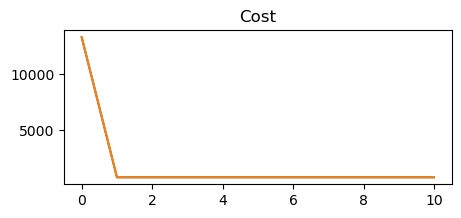

In [387]:
fig, ax = plt.subplots(figsize=(5,2))
ax.plot(jnp.stack(ev_costs))
ax.plot(jnp.stack(u_costs))
ax.set_title('Cost')

Text(0.5, 1.0, '$\\gamma$ est')

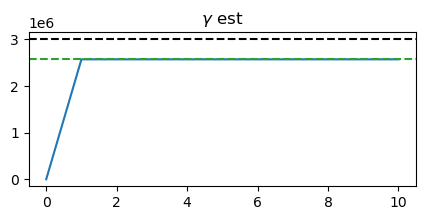

In [388]:
fig, ax = plt.subplots(figsize=(5,2))
ax.plot(jnp.stack(ev_ests).real)
ax.axhline(eigval, linestyle='dashed', color='k')
ax.axhline(oracle_evs[-1], linestyle='dashed', color='tab:green')
ax.set_title('$\\gamma$ est')

Text(0.5, 1.0, 'Cost')

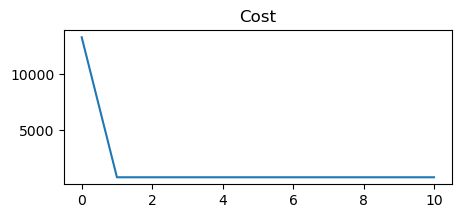

In [389]:
fig, ax = plt.subplots(figsize=(5,2))
ax.plot(jnp.stack(u_costs))
ax.set_title('Cost')

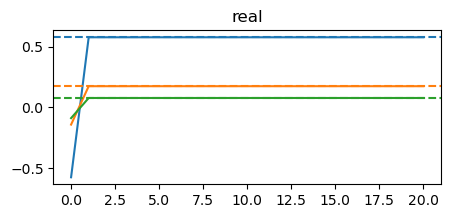

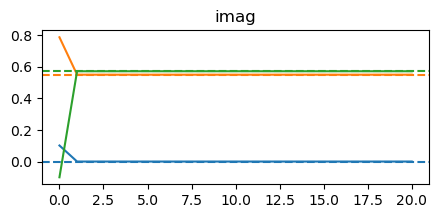

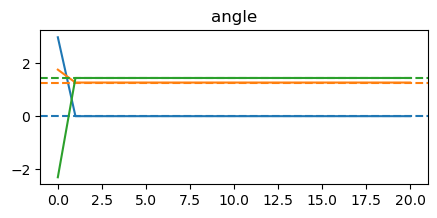

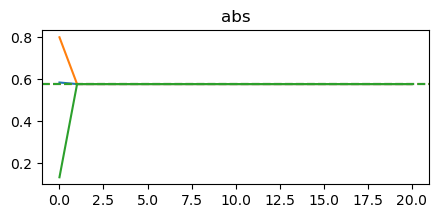

In [390]:
apps = [jnp.real, jnp.imag, jnp.angle, jnp.abs]

angle1 = jnp.angle(eigvec)[0]
eigvec_zeroed = eigvec * jnp.exp(-1j*angle1)

for app in apps:
    app_name = app.__name__
    fig, ax = plt.subplots(figsize=(5,2))
    def func(uiters, params):
        k = params[0]
        return app(uiters[:,k])
            

    for k in range(K):
        params = [k]
        ax.plot(func(jnp.stack(u_ests), params), color=colors[k])
        ax.axhline(app(eigvec_zeroed[k]), linestyle='dashed', color=colors[k])
    ax.set_title(f'{app_name}')
    plt.show()